In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
oil_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
sample_submission_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")
holiday_events_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
stores_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
train_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
transactions_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")

In [107]:
"""
Daily oil price. Includes values during both the train and test data timeframes.
(Ecuador is an oil-dependent country and it's economical health is highly vulnerable
to shocks in oil prices.)

Take into account that the stock market does not work on weekends. Therefore we will
have jumps in days that do not correspond to datapoints directly, i.e., the price
list with 1000 prices does not correspond to 1000 prices in row days, it is
the price of the first 1000 workdays (discarding holidays, festivities and weekends)
"""
print("Size of the pandas is: ", oil_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", oil_df.isnull().sum())
print(" ")
#It can be observed the only missing data is in oil_df
print("Information is: \n", oil_df.describe())
print(" ")


#Let´s add two columns for our interest:
oil_df["Month"]=oil_df["date"].apply(lambda x: int(x.split("-")[1]))
oil_df["Year"]=oil_df["date"].apply(lambda x: int(x.split("-")[0].strip()))
oil_df.head()

Size of the pandas is:  (1218, 4)
 
The number of null elements (NaN) is: 
 date           0
dcoilwtico    43
Month          0
Year           0
dtype: int64
 
Information is: 
         dcoilwtico        Month         Year
count  1175.000000  1218.000000  1218.000000
mean     67.714366     6.241379  2014.857143
std      25.630476     3.385288     1.355819
min      26.190000     1.000000  2013.000000
25%      46.405000     3.000000  2014.000000
50%      53.190000     6.000000  2015.000000
75%      95.660000     9.000000  2016.000000
max     110.620000    12.000000  2017.000000
 


,date,dcoilwtico,Month,Year
0,2013-01-01,NaN,1,2013
1,2013-01-02,93.14,1,2013
2,2013-01-03,92.97,1,2013
3,2013-01-04,93.12,1,2013
4,2013-01-07,93.20,1,2013


In [125]:
oil_df.Year.unique()
oil_df[oil_df.Year==2017]

,date,dcoilwtico,Month,Year
1044,2017-01-02,NaN,1,2017
1045,2017-01-03,52.36,1,2017
1046,2017-01-04,53.26,1,2017
1047,2017-01-05,53.77,1,2017
1048,2017-01-06,53.98,1,2017
...,...,...,...,...
1213,2017-08-25,47.65,8,2017
1214,2017-08-28,46.40,8,2017
1215,2017-08-29,46.46,8,2017
1216,2017-08-30,45.96,8,2017


In [147]:
print(oil_df.shape[0], oil_df["dcoilwtico"].shape[0])
oil_df.loc[oil_df['Year'] == 2013].index[0]


1218 1218


0

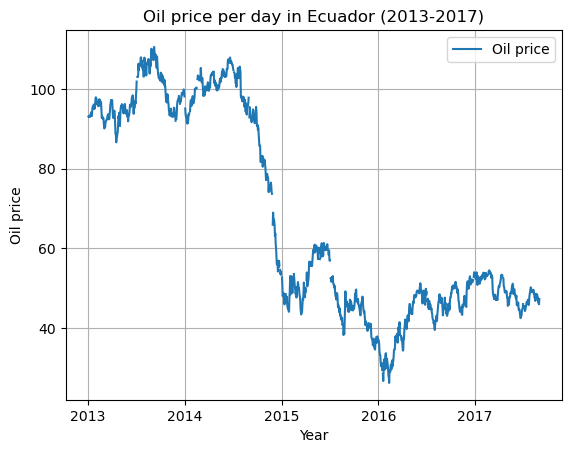

In [149]:
"""
Observe empty areas, that is the NaN part, we will make a tendency to make those missing data be filled
We will fill this data too with an RNN, training with the first not NaN and then filling the NaN part.
We will divide it in sections
"""

# xtick_positions=[0, 1*365, 2*365, 3*365, 4*365] #We can´t do this because of what we explained about weekdays and holidays before
xtick_positions=[oil_df.loc[oil_df['Year'] == 2013].index[0], oil_df.loc[oil_df['Year'] == 2014].index[0],
                 oil_df.loc[oil_df['Year'] == 2015].index[0], oil_df.loc[oil_df['Year'] == 2016].index[0],
                 oil_df.loc[oil_df['Year'] == 2017].index[0]]
xtick_labels=["2013", "2014", "2015", "2016", "2017"]

plt.plot(oil_df["date"], oil_df["dcoilwtico"], label="Oil price")
plt.title("Oil price per day in Ecuador (2013-2017)")
plt.xlabel("Year")
plt.ylabel("Oil price")
plt.xticks(xtick_positions, xtick_labels)
plt.legend()
plt.grid("True")

Text(0.5, 1.0, 'dcoilwtico Frequency per year')

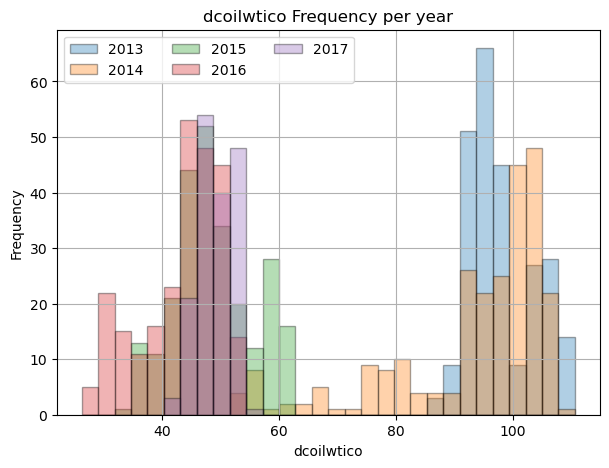

In [103]:
"""
Checking both plots, we can corroborate that the years that had the highest oil price were 2013 and 2014.
After year 2014 the price plumbed. Something happened.
"""


dcoilwtico_hist=pd.concat([oil_df[oil_df.Year==2013]['dcoilwtico'],oil_df[oil_df.Year==2014]['dcoilwtico'], oil_df[oil_df.Year==2015]['dcoilwtico'], oil_df[oil_df.Year==2016]['dcoilwtico'], oil_df[oil_df.Year==2017]['dcoilwtico']],axis=1)
dcoilwtico_hist.columns=["2013", "2014", "2015", "2016", "2017"]
dcoilwtico_hist.plot(kind="hist", bins=30, edgecolor="black", figsize=(7,5), alpha=0.35)
plt.xlabel("dcoilwtico")
plt.grid("True")
plt.legend(ncol=3)
plt.title("dcoilwtico Frequency per year")

In [109]:
print("Size of the pandas is: ", holiday_events_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", holiday_events_df.isnull().sum())
print(" ")
print("Information is: \n", holiday_events_df.describe())
print(" ")


#Let´s add two columns for our interest:
holiday_events_df["Month"]=holiday_events_df["date"].apply(lambda x: int(x.split("-")[1]))
holiday_events_df["Year"]=holiday_events_df["date"].apply(lambda x: int(x.split("-")[0].strip()))
holiday_events_df.head()

Size of the pandas is:  (350, 6)
 
The number of null elements (NaN) is: 
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
 
Information is: 
               date     type    locale locale_name description transferred
count          350      350       350         350         350         350
unique         312        6         3          24         103           2
top     2014-06-25  Holiday  National     Ecuador    Carnaval       False
freq             4      221       174         174          10         338
 


,date,type,locale,locale_name,description,transferred,Month,Year
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,3,2012
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012


In [162]:
# holiday_events_df["description"].unique() # Here we found that there was a worldwide futbol competition and an earthquake
# Let´s check the dates

longest_events_dates_df=pd.concat([holiday_events_df[holiday_events_df.description.str.contains("Mundial")], holiday_events_df[holiday_events_df.description.str.contains("Terremoto")]])
#These dates can be of interest. Let´s observe when these two events started:
print("Mundial in Brazil started: {} and Earthquake stated: {}".format(holiday_events_df.iloc[holiday_events_df[holiday_events_df.description.str.contains("Mundial")].index[0]]["date"],
                                                                      holiday_events_df.iloc[holiday_events_df[holiday_events_df.description.str.contains("Terremoto")].index[0]]["date"]))

Mundial in Brazil started: 2014-06-12 and Earthquake stated: 2016-04-16


In 2014 they were almost at their top in oil price and in 2016 they were almost at the bottom. The earthquake undermined the oil price at that moment with the last dump.

In [168]:
"""
stores.csv:

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.
"""
print("Size of the pandas is: ", stores_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", stores_df.isnull().sum())
print(" ")
print("Information is: \n", stores_df.describe())
print(" ")

stores_df.head()

Size of the pandas is:  (54, 5)
 
The number of null elements (NaN) is: 
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
 
Information is: 
        store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000
 


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [170]:
"""
train.csv:

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

store_nbr: identifies the store at which the products are sold.
family: identifies the type of product sold.
sales: gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion: gives the total number of items in a product family that were being promoted at a store at a given date.
"""

print("Size of the pandas is: ", train_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", train_df.isnull().sum())
print(" ")
print("Information is: \n", train_df.describe())
print(" ")

#Let´s add two columns for our interest:
train_df["Month"]=train_df["date"].apply(lambda x: int(x.split("-")[1]))
train_df["Year"]=train_df["date"].apply(lambda x: int(x.split("-")[0]))
train_df["Day"]=train_df["date"].apply(lambda x: int(x.split("-")[2]))
                                                         
train_df.head()

Size of the pandas is:  (3000888, 6)
 
The number of null elements (NaN) is: 
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
 
Information is: 
                  id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02
 


,id,date,store_nbr,family,sales,onpromotion,Month,Year,Day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,2013,1
1,1,2013-01-01,1,BABY CARE,0.0,0,1,2013,1
2,2,2013-01-01,1,BEAUTY,0.0,0,1,2013,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,2013,1
4,4,2013-01-01,1,BOOKS,0.0,0,1,2013,1


In [ ]:
train_df[(train_df.store_nbr==1) & (train_df.Year==2013) & (train_df.Month==1)]

In [213]:
train_df.loc[train_df['Year'] == 2014].index[0]

648648

array([   0,    1,    2, ..., 1681, 1682, 1683])

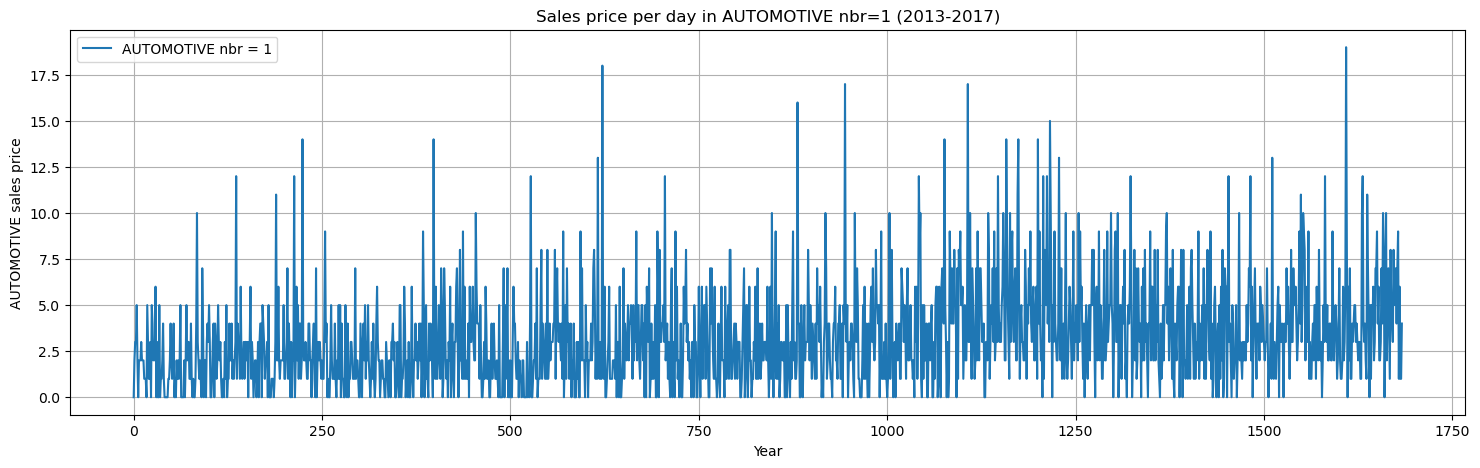

In [211]:
xtick_positions=[train_df.loc[train_df['Year'] == 2013].index[0], train_df.loc[train_df['Year'] == 2014].index[0],
                 train_df.loc[train_df['Year'] == 2015].index[0], train_df.loc[train_df['Year'] == 2016].index[0],
                 train_df.loc[train_df['Year'] == 2017].index[0]]
xtick_labels=["2013", "2014", "2015", "2016", "2017"]

plt.figure(figsize=(18,5))
plt.plot(np.arange(len(train_df[(train_df.store_nbr==1) & (train_df.family=="AUTOMOTIVE")].sales)),
         train_df[(train_df.store_nbr==1) & (train_df.family=="AUTOMOTIVE")].sales, label="AUTOMOTIVE nbr = 1")
plt.title("Sales price per day in AUTOMOTIVE nbr=1 (2013-2017)")
plt.xlabel("Year")
plt.ylabel("AUTOMOTIVE sales price")
#plt.xticks(xtick_positions, xtick_labels)
plt.legend()
plt.grid("True")

In [ ]:
print(len(train_df["store_nbr"].unique()), len(stores_df["store_nbr"].unique()))
#Let´s create a full dataset containing all the common features of all df

In [178]:
"""

print(train_df.store_nbr.unique(), 
      train_df.family.unique(),
     len(train_df.sales.unique()),
     train_df.onpromotion.unique())
"""

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9] ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD'] 379610 [  0   3   5   1  56  20  19   2   4  18  17  12   6   7  10   9  50   8
  16  42  51  13  15  47  21  40  37  54  24  58  22  59  11  45  25  55
  26  43  35  14  28  46  36  32  53  57  27  39  41  30  29  49  23  48
  44  38  31  52  33  34  61  60 116  86  73 113 102  68 104  93  70  92
 121  72 178 174 161 118 105 172 163 167 142 154 133 180 181 173 165 168


In [44]:
print("Size of the pandas is: ", test_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", test_df.isnull().sum())
print(" ")
print("Information is: \n", test_df.describe())
print(" ")
test_df.head()
#We have to predict sales. We will use a RNN (LSTM)

Size of the pandas is:  (28512, 5)
 
The number of null elements (NaN) is: 
 id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
 
Information is: 
                  id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.000000
50%    3.015144e+06     27.500000      0.000000
75%    3.022271e+06     41.000000      6.000000
max    3.029399e+06     54.000000    646.000000
 


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [45]:
print("Size of the pandas is: ", transactions_df.shape)
print(" ")
print("The number of null elements (NaN) is: \n", transactions_df.isnull().sum())
print(" ")
print("Information is: \n", transactions_df.describe())
print(" ")
transactions_df.head()

Size of the pandas is:  (83488, 3)
 
The number of null elements (NaN) is: 
 date            0
store_nbr       0
transactions    0
dtype: int64
 
Information is: 
           store_nbr  transactions
count  83488.000000  83488.000000
mean      26.939237   1694.602158
std       15.608204    963.286644
min        1.000000      5.000000
25%       13.000000   1046.000000
50%       27.000000   1393.000000
75%       40.000000   2079.000000
max       54.000000   8359.000000
 


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


(3000888, 6)